# INF4480 Spring of 2021 - Project 4
### By Olav Fønstelien 2021-03-16
<br>

### Notes:
* Implementation in Python using NumPy, SciPy, matplotlib
* Including most of the code since I myself think it is always interesting to see how things were done, and would also like feedback as well as tips and tricks
* I tried generating slides using ```nbconvert```, but the special detection threshold would not render corrrectly, so I  submit in original Jupyter Notebook format. Hope that's OK.

## Introduction

In this assignment we will look at different binary detectors, CFAR, ML and Bayes, and see how they perform relative to each other.

Before we start, let's first set up the Python environment:

In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt, log
from scipy.stats import norm
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['pcolor.shading'] = 'flat'

## Assignment 1 - Constant False Alarm Rate (CFAR) Detector

#### **a)**
The PDF of the signal in noise is given by $f_{\theta}(x) \sim \mathcal{N}(\theta, \sigma^2)$.

#### **b)** 
The false-alarm-rate $P_{FA}$ of a CFAR detector depends on both $\theta, \sigma$. Given the _Neyman-Pearson_ criterion
$$
\Lambda (x) = \frac{f_{\theta}(x)}{f_{n}(x)} 
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\lambda
\stackrel{\text{monotonic}}{\Rightarrow}
\ln \Lambda (x) = \frac{1}{\sigma^2} \bigg( x \theta - \frac{\theta^2}{2} \bigg)
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\ln \lambda
$$
We rearrange and get the threshold $\gamma$ between the hypotheses
$$
x
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\frac{\sigma^2 \ln \lambda}{\theta} + \frac{\theta}{2} = \gamma
$$
We know that the false-alarm-rate is given by
$$
P_{FA} = \int_{\Lambda(x)>\lambda} f_n(x) dx = \int_{\gamma}^\infty f_n(x) dx = Q_n(\gamma) = Q_n \bigg( \frac{\sigma^2 \ln \lambda}{\theta} + \frac{\theta}{2} \bigg)
$$

#### **c)**
The false-alarm-rate $P_{FA}$ and the detection-rate $P_D$ are linked by the common detection threshold $\gamma$;
$$
\begin{aligned}
P_{FA} &= Q_n(\gamma) = Q \bigg( \frac{\gamma}{\sigma} \bigg) \\
P_{D} &= Q_{\theta}(\gamma) = Q \bigg( \frac{\gamma - \theta}{\sigma} \bigg)
\end{aligned}
$$
where $Q(\cdot)$ is the normalized survival function. Given $P_{FA} = \alpha$, we can calculate the detection-rate directly by
$$
P_{D} = Q_{\theta}(\sigma Q_n^{-1}(\alpha)) = Q \bigg( Q^{-1}(\alpha) - \frac{\theta}{\sigma} \bigg)
$$
Plugging in $\theta = 5, \sigma = 5$, and $\alpha=0.1$ we get the rather poor detection-rate $ P_{D} = 0.39 $.

In [2]:
# Calculating detection rate
sigma, theta = 5, 5
alpha = .1
P_D = norm.sf(norm.isf(alpha)-theta/sigma)
P_D

0.389143691645361

#### **d)**
Varying the threshold $\gamma$, we can plot the Receiver Operator Characteristic (ROC) Curves for the detector. Using again that
$$
\begin{aligned}
P_{FA} &= Q \bigg( \frac{\gamma}{\sigma} \bigg) \\
P_{D} &= Q \bigg( \frac{\gamma - \theta}{\sigma} \bigg)
\end{aligned}
$$
we see that $P_{FA} = P_D = 1$ for the negative asymptote, $\gamma = - \infty$; and likewise $P_{FA} = P_D = 0$ for the positive asymptote, $\gamma = + \infty$. For a signal in noise, we define the signal-to-noise ratio as
$$
\mathrm{SNR} = \frac{\theta}{\sigma}
$$
We see that $\mathrm{SNR} \ge 0$, and that equality is achieved when either $\theta=0$; or at the limit $\sigma \rightarrow \infty$. These cases represent the straight line between the asymptotes of the threshold on the ROC curve. For all $\mathrm{SNR} > 0$, $P_{FA} > P_D$, and the curve bends upwards towards the upper left corner for increasing $\mathrm{SNR}$.

Below we see the ROC curve for some $\sigma$ at fixed $\theta$.

In [3]:
# Generating ROC curves
theta = 5
sigmas = np.array([1,3,5,10,15]).reshape(-1,1)
gamma = np.linspace(-1000,1000,10000)
P_D = norm.sf((gamma-theta)/sigmas)
P_FA = norm.sf(gamma/sigmas)

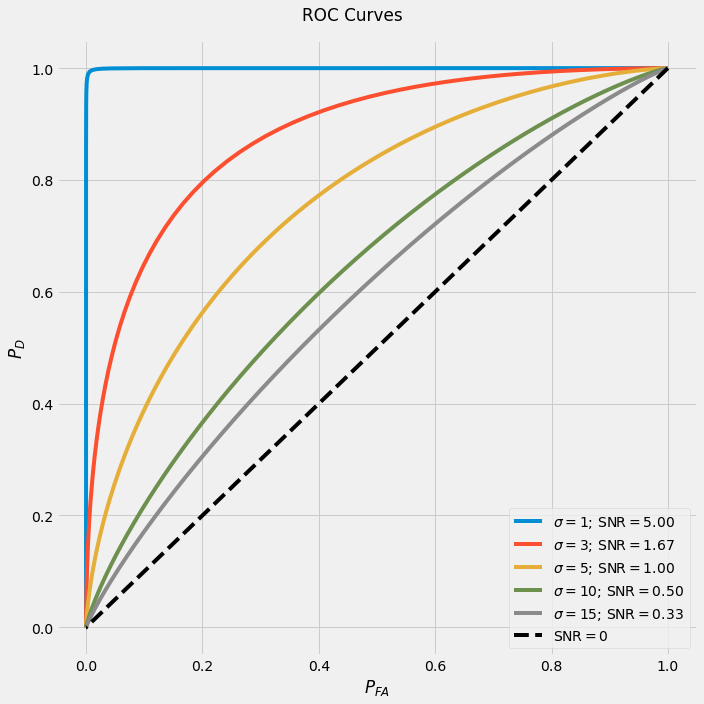

In [4]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'ROC Curves')

ax = axes
ax.plot(P_FA.T, P_D.T)
ax.plot(P_FA[0], P_FA[0], color='0', ls='--')
ax.legend([rf'$\sigma={sigma}$; $\mathrm{{SNR}}={theta/sigma:.2f}$' for sigma in sigmas.squeeze()] + [r'$\mathrm{SNR}=0$'])

ax.set_xlabel(r'$P_{FA}$')
ax.set_ylabel(r'$P_{D}$')


plt.tight_layout()
plt.show()

#### **e)**
In the figure below we see the reason why the performance of the detector in **c)** was poor. The detection rate is given by the area under the "noise+signal" curve, and we see that this covers less than half the area, since
$$
\theta = 5 < \sigma Q^{-1}(\alpha) = 5 \cdot 1.28... \approx 6.4
$$
The variance of PDF of the noise is too high relative to the signal magnitude, i.e. the signal-to-noise ratio is too low; $\mathrm{SNR} = 5/5 = 1$. To help on this situation, we can increase the number of samples, as we will see next.

In [5]:
# Generating PDFs
sigma, theta = 5, 5
x = np.linspace(-25,25,1000)
fn = norm.pdf(x, loc=0, scale=sigma)
fs = norm.pdf(x, loc=theta, scale=sigma)

# Threshold
alpha = .1
gamma = norm.isf(alpha)*sigma

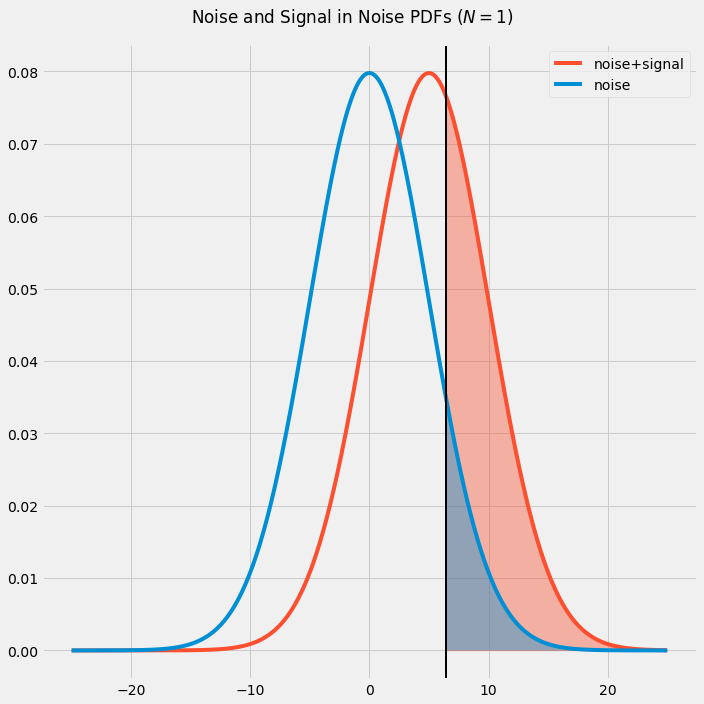

In [6]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'Noise and Signal in Noise PDFs ($N=1$)')

ax = axes
ax.plot(x, fs, color=COLORS[1])
ax.fill_between(x, np.zeros(x.shape), fs, where=x>gamma, color=COLORS[1], alpha=.4)

ax.plot(x, fn)
ax.fill_between(x, np.zeros(x.shape), fn, where=x>gamma, alpha=.4)
ax.legend(['noise+signal', 'noise'])
ax.axvline(x=gamma, ymin=0, ymax=1, lw=2, color='0')

plt.tight_layout()
plt.show()

#### **f)**
To imrove the signal-to-noise ratio of our detector, we increase the number of samples we look at before we take a decision about which PDF the samples are drawn from. We do this by first defining a new random variable, $z$, which we let represent the sum of the $N$ samples from $x$, now denoted $x_n$. Under this variable, the hypotheses become
$$
\begin{aligned}
H_0 &: z = \sum_{n=0}^{N-1} x_n = \sum_{n=0}^{N-1} n_n \\
H_1 &: z = \sum_{n=0}^{N-1} x_n = \sum_{n=0}^{N-1} (\theta + n_n) \\
\end{aligned}
$$
The statistics of $z$ are given by
$$
\begin{aligned}
\theta_z &= \mathbb{E}(z) \stackrel{H_1}{=} \mathbb{E} \bigg[ \sum_{n=0}^{N-1} (\theta + n_n) \bigg] = N \theta \\
\sigma_z^2 &= \mathbb{E}(z^2) \stackrel{H_0}{=} \mathbb{E} \bigg[ \bigg(  \sum_{n=0}^{N-1} n_n \bigg)^2 \bigg] = 
\mathbb{E} \bigg[ \bigg(\sum_{n=0}^{N-1} n_n \bigg) \bigg(\sum_{m=0}^{N-1} n_m \bigg) \bigg] = 
\mathbb{E} \bigg[ \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} n_n n_m \bigg] \\
&= \mathbb{E} \bigg[ \sum_{n=0}^{N-1} n_n^2 + \sum_{n \neq m} n_n n_m \bigg] = \mathbb{E} \big[ N\sigma^2 + 0 \big] = N\sigma^2
\end{aligned}
$$
This gives us the hypotheses
$$
\begin{aligned}
H_0 &: z \sim \mathcal{N}(0, N\sigma^2) \\
H_1 &: z \sim \mathcal{N}(N\theta, N\sigma^2) \\
\end{aligned}
$$
Given design paramaters $P_{FA} = 0.01 = \alpha, P_D > 0.9 = \beta$, we may use the survival functions to derive the threshold $\gamma$, as we did in **c)**;
$$
P_D = Q \bigg( \frac{\gamma - N\theta}{\sqrt{N}\sigma} \bigg) > \beta \stackrel{\text{antitonic}}{\Rightarrow} \frac{\gamma - N\theta}{\sqrt{N}\sigma} < Q^{-1}(\beta)
$$
and likewise for the false-alarm-rate
$$
P_{FA} = Q \bigg( \frac{\gamma}{\sqrt{N}\sigma} \bigg) = \alpha \Rightarrow \frac{\gamma}{\sqrt{N}\sigma} = Q^{-1}(\alpha)
$$
We solve the last equation w.r.t. $\gamma$;
$$
\gamma = \sqrt{N}\sigma Q^{-1}(\alpha)
$$
and insert it into the first (for $P_D$), which gives us the needed number of samples to make;
$$
N > \mathrm{ceil} \bigg[ \bigg(\frac{\sigma}{\theta}\bigg)^2 \bigg( Q^{-1}(\alpha) - Q^{-1}(\beta) \bigg)^2 \bigg] \approx \mathrm{ceil} [13.02] = 14
$$
We note that $N$ increases with the inverse of the squared signal-to-noise ratio.

In [7]:
# Calculating minimum number of samples
sigma, theta = 5, 5
P_D, P_FA = .9, .01
N = (sigma/theta*(norm.isf(P_FA) - norm.isf(P_D)))**2
N = np.ceil(N)
gamma = norm.isf(P_FA)*sqrt(N)*sigma
N, gamma

(14.0, 43.52198353555383)

In [8]:
# Controlling result
norm.sf(gamma, loc=0, scale=sigma*sqrt(N)), norm.sf(gamma, loc=N*theta, scale=sigma*sqrt(N))

(0.010000000000000016, 0.9215111164534591)

#### **g)**
The result is shown in the figure below. We see that sampling with $N > 1$ reduces the standard deviation of the noise relative to signal magnitude, and thereby improves the signal-to-noise ratio;
$$
\mathrm{SNR}_z = \frac{\theta_z}{\sigma_z} = \frac{N\theta}{\sqrt{N}\sigma} = \sqrt{N} \frac{\theta}{\sigma} = \sqrt{N} \cdot \mathrm{SNR}_x
$$

In [9]:
# Generating PDFs
N = 14
sigma, theta = sqrt(N)*5, N*5
x = np.linspace(-75,150,10000)
fn = norm.pdf(x, loc=0, scale=sigma)
fs = norm.pdf(x, loc=theta, scale=sigma)

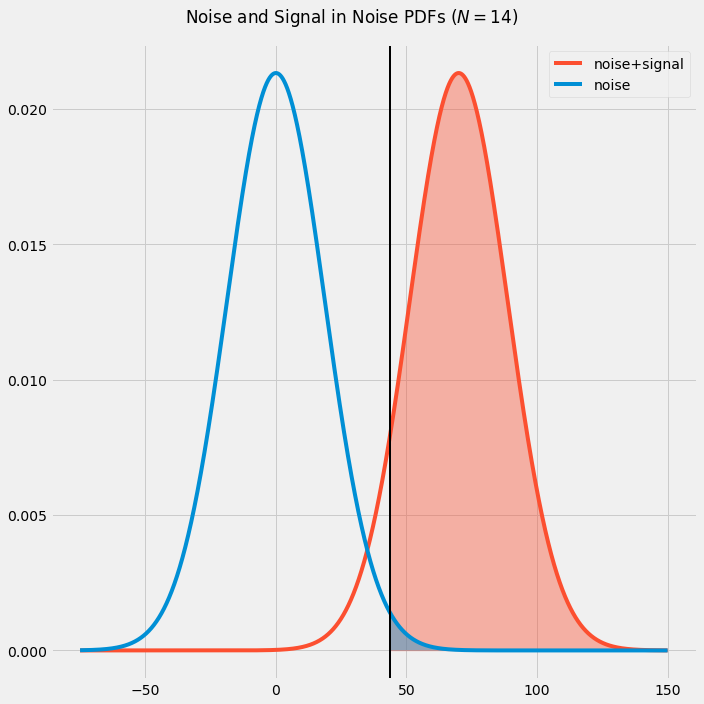

In [10]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'Noise and Signal in Noise PDFs ($N=14$)')

ax = axes
ax.plot(x, fs, color=COLORS[1])
ax.fill_between(x, np.zeros(x.shape), fs, where=x>gamma, color=COLORS[1], alpha=.4)

ax.plot(x, fn)
ax.fill_between(x, np.zeros(x.shape), fn, where=x>gamma, alpha=.4)
ax.legend(['noise+signal', 'noise'])
ax.axvline(x=gamma, ymin=0, ymax=1, lw=2, color='0')

plt.tight_layout()
plt.show()

## Assignment 2 - Maximum Likelihood (ML) Detector

#### **a)**
The ML detector is given by the criterion
$$
f_{\theta}(x)
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
f_{n}(x)
$$
We can reuse the threshold we found for the CFAR detector in **b)**, but with $\lambda = 1$;
$$
x
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\frac{\sigma^2 \ln \lambda}{\theta} + \frac{\theta}{2} = 0 + \frac{\theta}{2} = \frac{\theta}{2} = \gamma
$$
Thus, with parameters $\sigma=3/13, \theta=1$, we get $\gamma = 1/2$, which corresponds to;
$$
\begin{aligned}
P_{FA} &= Q \bigg( \frac{\gamma}{\sigma} \bigg) = 0.015\\
P_{D} &= Q \bigg( \frac{\gamma - \theta}{\sigma} \bigg) = 0.985\\
P_{M} &= 1 - P_{D} = 0.015\\
\end{aligned}
$$

In [11]:
# Calculating P_FA, P_D, P_M
sigma, theta = 3/13, 1
gamma = 1/2
P_FA = norm.sf(gamma/sigma)
P_D = norm.sf((gamma-theta)/sigma)
P_M = 1 - P_D
P_FA, P_D, P_M

(0.015130140010235814, 0.9848698599897642, 0.015130140010235826)

#### **b)**
We will now generate some data to see how our ML detector performs. Let's first create a file with a few words ...

In [12]:
!echo "hei diddelidi teater er mitt liv" > signal-original.txt

... and feed this into the MATLAB file ```SignalFromString.m```, which was provided with the assignment. This generates a binary encoding of the text in ```signal-original.txt```, repeated an optional number of times, ```N```. Let's use ```N=3```, and store the result in the file ```signal-encoded.txt``` ...

```matlab
% MATLAB
>> s0 = SignalFromName('signal-original.txt', 3)
>> writematrix(s0, 'signal-encoded.txt')
```

In [13]:
!head signal-encoded.txt

0
1
1
1
0
0
1
1
0
1


We read this into Python and add some AGW noise with std-dev $\sigma = 3/13$. The result is seen in the figure below.

In [14]:
# Generating noisy signal
df = pd.read_csv('signal-encoded.txt')
s0 = df.to_numpy().squeeze()
sn = s0 + np.random.randn(s0.shape[0])*sigma

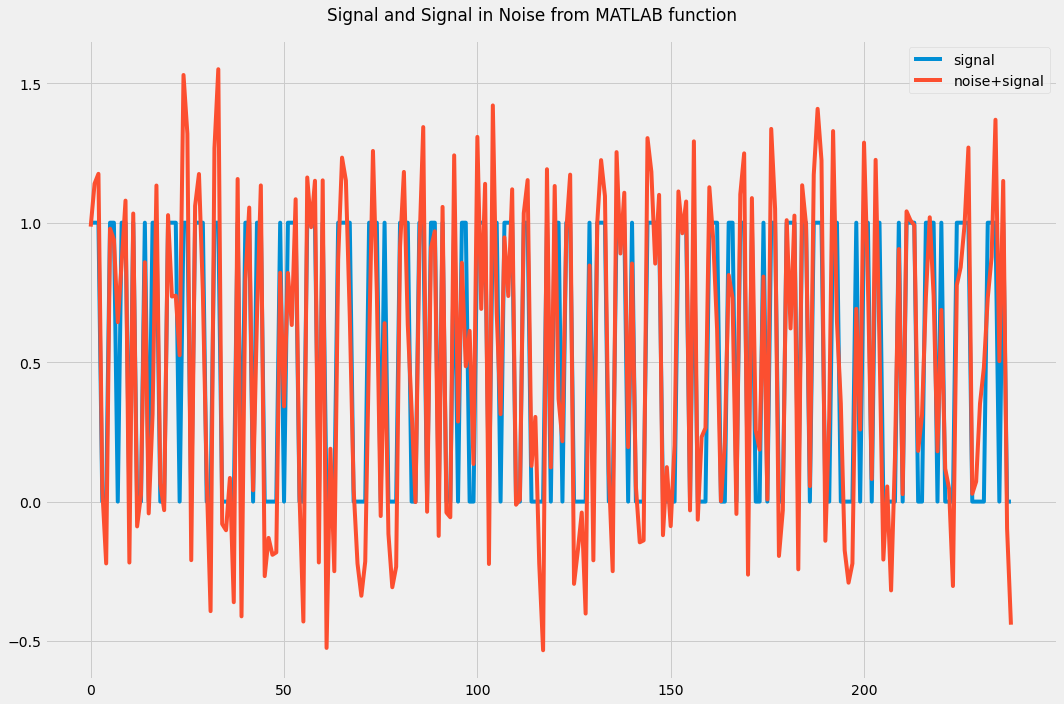

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(15,10))
fig.suptitle(r'Signal and Signal in Noise from MATLAB function')

ax = axes
ax.plot(s0)
ax.plot(sn, color=COLORS[1])
ax.legend(['signal', 'noise+signal'])

plt.tight_layout()
plt.show()

Now, applying the ML detector with threshold $\gamma = 1/2$, we get

In [16]:
# Detecting signal
gamma = 1/2
sd = 1*(sn > gamma)

Let's plot the difference between ```sd-d0``` the signals to see how the detector performs;

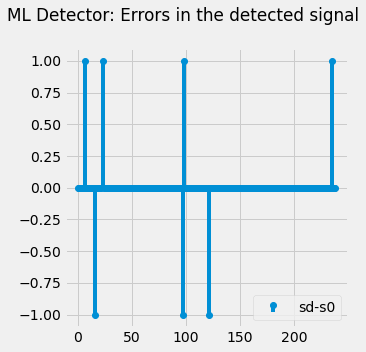

In [17]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(5,5))
fig.suptitle(r'ML Detector: Errors in the detected signal')

ax = axes
ax.stem(sd-s0, basefmt=' ')
ax.legend(["sd-s0"])

plt.tight_layout()
plt.show()

Here, the instances ```sd-s0 > 0``` correspond to false alarms (FA), and ```sd-s0 < 0``` correspond to the misses (M). The rate for each are
$$
\begin{aligned}
P_{FA} &= 0.0042\\
P_{D} &= 0.987\\
P_{M} &=0.0123\\
\end{aligned}
$$
$P_D, P_M$ are quite close to the calculated rates of 0.985/0.015 found in **a)**, while $P_{FA}$ is somewhat below the calculated, which was 0.015. Increasing ```N``` in the MATLAB function would probably give us a better estimate for $P_{FA}$.

In [18]:
# Calculating P_FA, P_D, P_M in the detected signal
P_FA = np.sum(sd-s0>0)/s0.shape[0]
P_M = np.sum(sd-s0<0)/s0.shape[0]
P_D = 1 - P_M
P_FA, P_D, P_M

(0.016736401673640166, 0.9874476987447699, 0.012552301255230125)

#### **c)**
The corresponding Bayes' detector with costs $C_{00} = C_{11} = 0$ and $C_{01} = C_{10} = 1$ is given by
$$
\frac{f_{\theta}(x)}{f_{n}(x)}
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\frac{P_n}{P_{\theta}}
$$
where $P_n, P_{\theta}$ are the relative frequencies of each hypothesis. Using the observed rates to estimate $P_n, P_{\theta}$, we get
$$
\begin{aligned}
P_{n} &= 0.481\\
P_{\theta} &= 0.519\\
\end{aligned}
$$

In [19]:
# Calculating the rates of each hypothesis
P_n = np.sum(sd < 1)/sd.shape[0]
P_t = np.sum(sd > 0)/sd.shape[0]
P_n, P_t

(0.4686192468619247, 0.5313807531380753)

We insert this into the result from **1b)**, with $\lambda = \frac{P_n}{P_{\theta}}$, and again obtain the threshold $\gamma$;
$$
x
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\frac{\sigma^2 \ln \frac{P_n}{P_{\theta}}}{\theta} + \frac{\theta}{2} =  = \gamma
$$

In [20]:
# Calculating the threshold gamma
sigma, theta = 3/13, 1
gamma_b = sigma**2*log(P_n/P_t)/theta + theta/2
gamma_b

0.49330654475460667

In [21]:
# Detecting signal with Bayes'
sd = 1*(sn > gamma_b)

Let's again plot the difference between ```sd-d0``` the signals to see how Bayes' Detector performs;

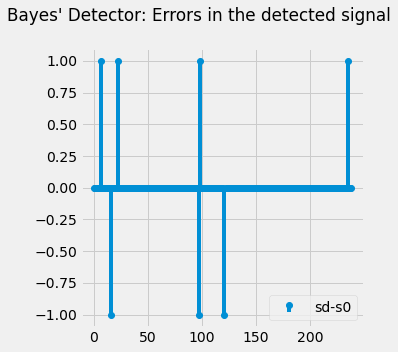

In [22]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(5,5))
fig.suptitle(r"Bayes' Detector: Errors in the detected signal")

ax = axes
ax.stem(sd-s0, basefmt=' ')
ax.legend(["sd-s0"])

plt.tight_layout()
plt.show()

As in **b)**, the instances ```sd-s0 > 0``` correspond to false alarms (FA), and ```sd-s0 < 0``` correspond to the misses (M). The rate for each under the Bayes criterion are
$$
\begin{aligned}
P_{FA} &= 0.0042\\
P_{D} &= 0.992\\
P_{M} &=0.0084\\
\end{aligned}
$$
We see that $P_D, P_M$ are improved slightly from found in **b)**, while $P_{FA}$ remains the same. Again, increasing ```N``` in the MATLAB function would probably give us better estimates for all rates.

In [23]:
# Calculating P_FA, P_D, P_M in the detected signal
P_FA = np.sum(sd-s0>0)/s0.shape[0]
P_M = np.sum(sd-s0<0)/s0.shape[0]
P_D = 1 - P_M
P_FA, P_D, P_M

(0.016736401673640166, 0.9874476987447699, 0.012552301255230125)

#### **d)**
Below we see plots of the PDFs for each case
ML:
$$
\begin{aligned}
\text(ML): f_i^{(ML)}(x) = \frac{1}{2} \cdot f_i(x) \\
\text(Bayes'): f_i^{(Bayes)}(x) = P_i \cdot f_i(x)
\end{aligned}
$$
We see that Bayes' is ML scaled by the relative rate, $2P_i$. Below we have plotted the PDFs for both ML and Bayes'.

In [24]:
# Generating PDFs
sigma, theta = 3/13, 1
x = np.linspace(-1.5,2,1000)
fn = .5*norm.pdf(x, loc=0, scale=sigma)
ft = .5*norm.pdf(x, loc=theta, scale=sigma)

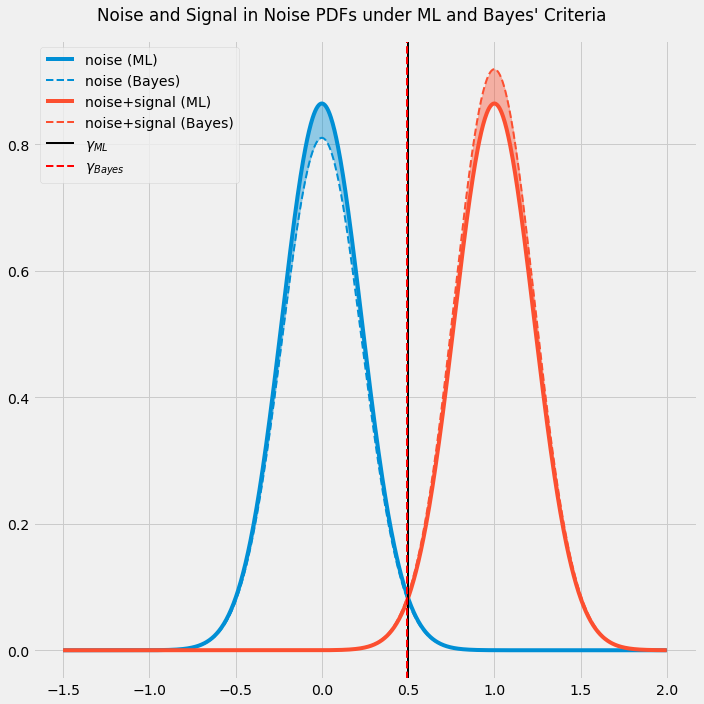

In [25]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r"Noise and Signal in Noise PDFs under ML and Bayes' Criteria")

fnb = fn*P_n*2
ftb = ft*P_t*2

ax = axes
ax.plot(x, fn, color=COLORS[0])
ax.plot(x, fnb, color=COLORS[0], ls='--', lw=2)
ax.fill_between(x, fn, fnb, color=COLORS[0], alpha=.4)
ax.plot(x, ft, color=COLORS[1])
ax.plot(x, ftb, color=COLORS[1], ls='--', lw=2)
ax.fill_between(x, ft, ftb, color=COLORS[1], alpha=.4)

ax.axvline(x=gamma, ymin=0, ymax=1, lw=2, color='0')
ax.axvline(x=gamma_b, ymin=0, ymax=1, lw=2, color='red', ls='--')

ax.legend(['noise (ML)', 'noise (Bayes)', 'noise+signal (ML)', 'noise+signal (Bayes)', r'$\gamma_{ML}$', r'$\gamma_{Bayes}$'])

plt.tight_layout()
plt.show()